In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


In [2]:
xlsx=pd.ExcelFile('EastWestAirlines.xlsx')

In [3]:
df=xlsx.parse('data')

In [4]:
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [5]:
df=df.drop(columns=['ID#'])

In [6]:
df.shape

(3999, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award?             3999 non-null   int64
dtypes: int64(11)
memory usage: 343.8 KB


In [8]:
df.isnull().any()

Balance              False
Qual_miles           False
cc1_miles            False
cc2_miles            False
cc3_miles            False
Bonus_miles          False
Bonus_trans          False
Flight_miles_12mo    False
Flight_trans_12      False
Days_since_enroll    False
Award?               False
dtype: bool

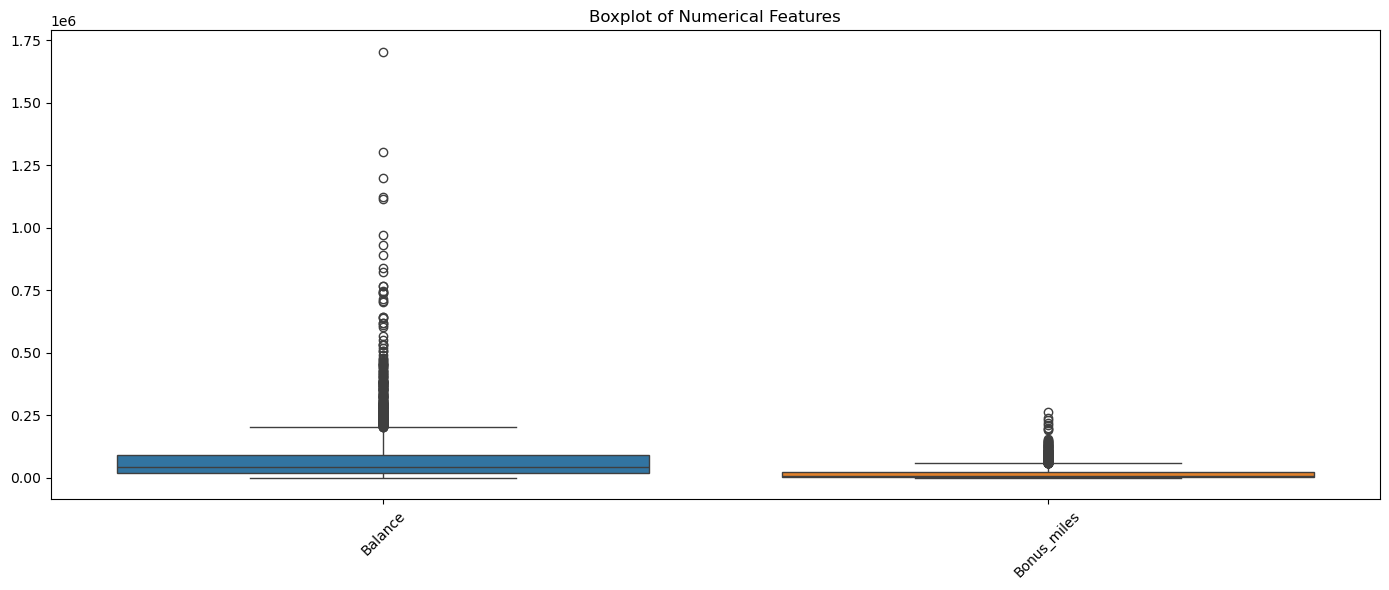

In [9]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[['Balance','Bonus_miles']])
plt.xticks(rotation=45)
plt.title("Boxplot of Numerical Features")
plt.tight_layout()
plt.show()

In [10]:
df_processed = df.copy()
for col in df_processed.columns:
    if df_processed[col].dtype in ['int64', 'float64'] and col != 'Award?':  # Exclude target column
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_processed = df_processed[(df_processed[col] >= lower_bound) & (df_processed[col] <= upper_bound)]

In [11]:
df.shape

(3999, 11)

In [12]:
df_processed.shape

(2370, 11)

In [13]:
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    return outliers

In [14]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != 'Award?']
numerical_cols

['Balance',
 'Qual_miles',
 'cc1_miles',
 'cc2_miles',
 'cc3_miles',
 'Bonus_miles',
 'Bonus_trans',
 'Flight_miles_12mo',
 'Flight_trans_12',
 'Days_since_enroll']

In [15]:
def treat_outliers(df,numeric_cols):
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower,np.where(df[col] > upper, upper, df[col]))
    return df
df=treat_outliers(df,numerical_cols)

In [16]:
for i in numerical_cols:
    count=detect_outliers_iqr(df,i)
    print(f"Number of ouliers in {i} : {len(count)}")

Number of ouliers in Balance : 0
Number of ouliers in Qual_miles : 0
Number of ouliers in cc1_miles : 0
Number of ouliers in cc2_miles : 0
Number of ouliers in cc3_miles : 0
Number of ouliers in Bonus_miles : 0
Number of ouliers in Bonus_trans : 0
Number of ouliers in Flight_miles_12mo : 0
Number of ouliers in Flight_trans_12 : 0
Number of ouliers in Days_since_enroll : 0


In [17]:
# Separate features and target
X = df.drop(columns=['Award?'])  # Features
y = df['Award?']   

In [18]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

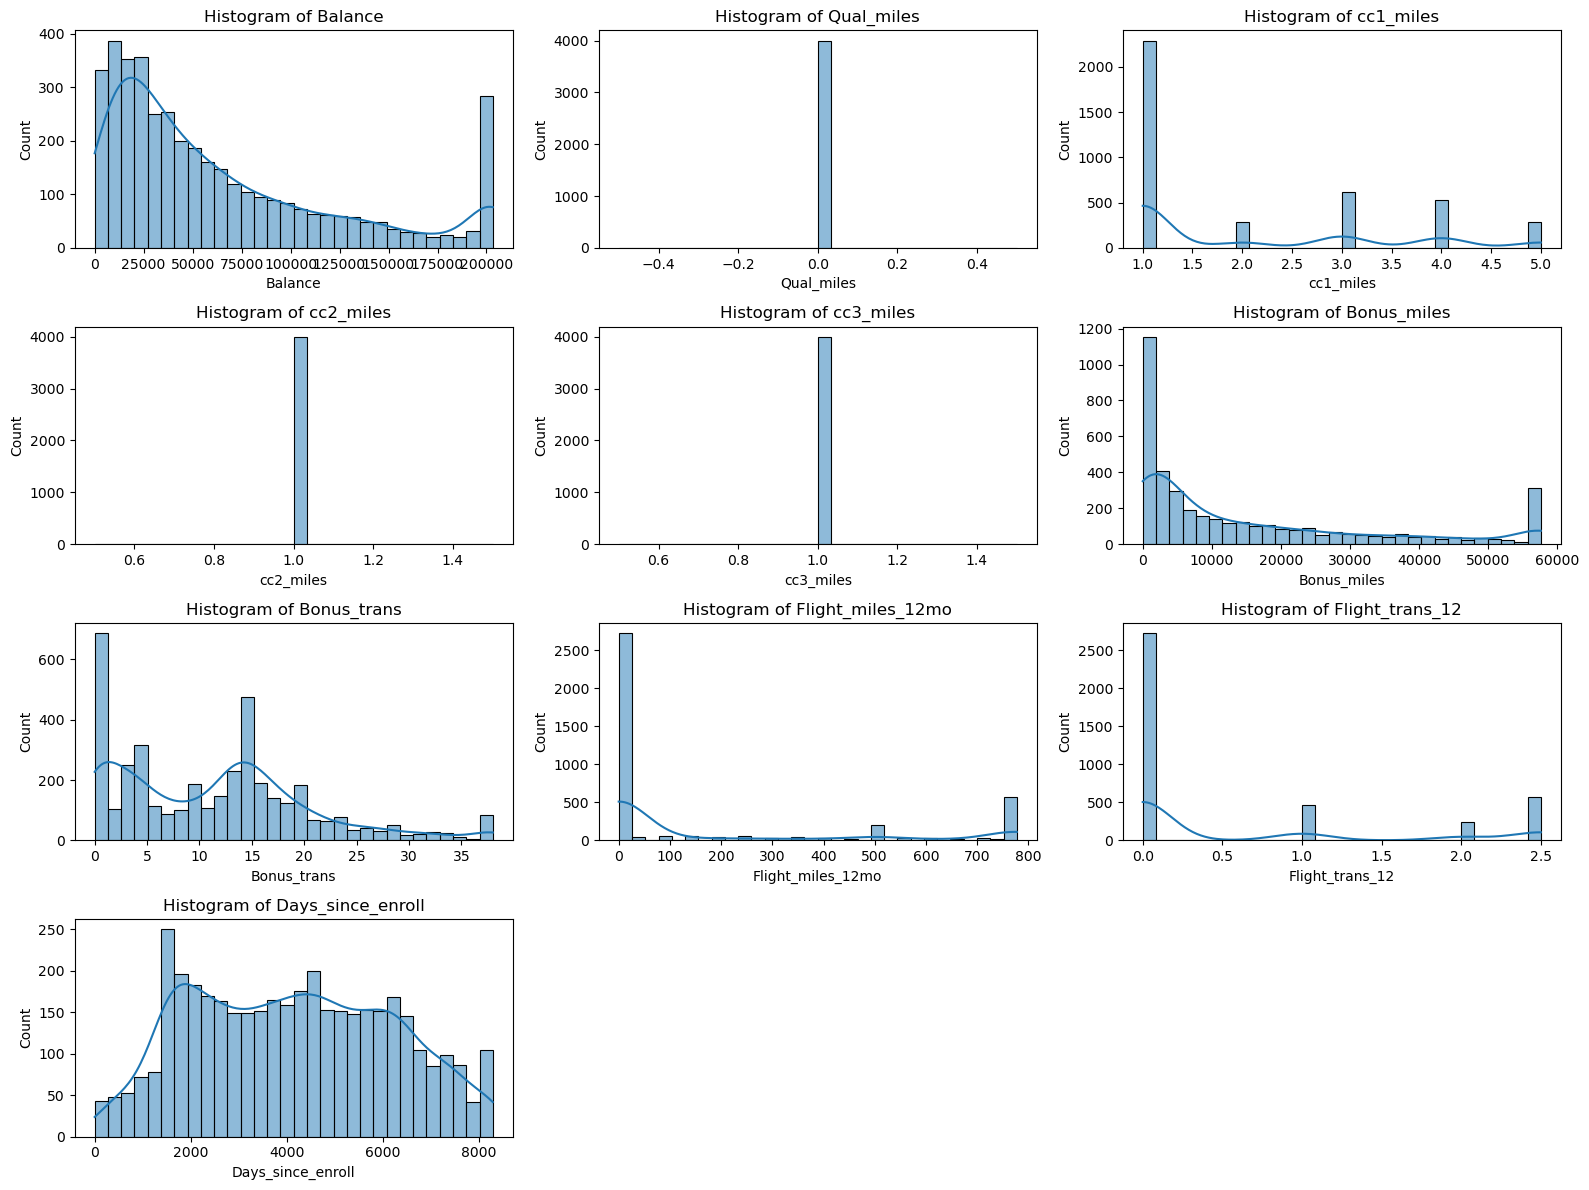

In [19]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

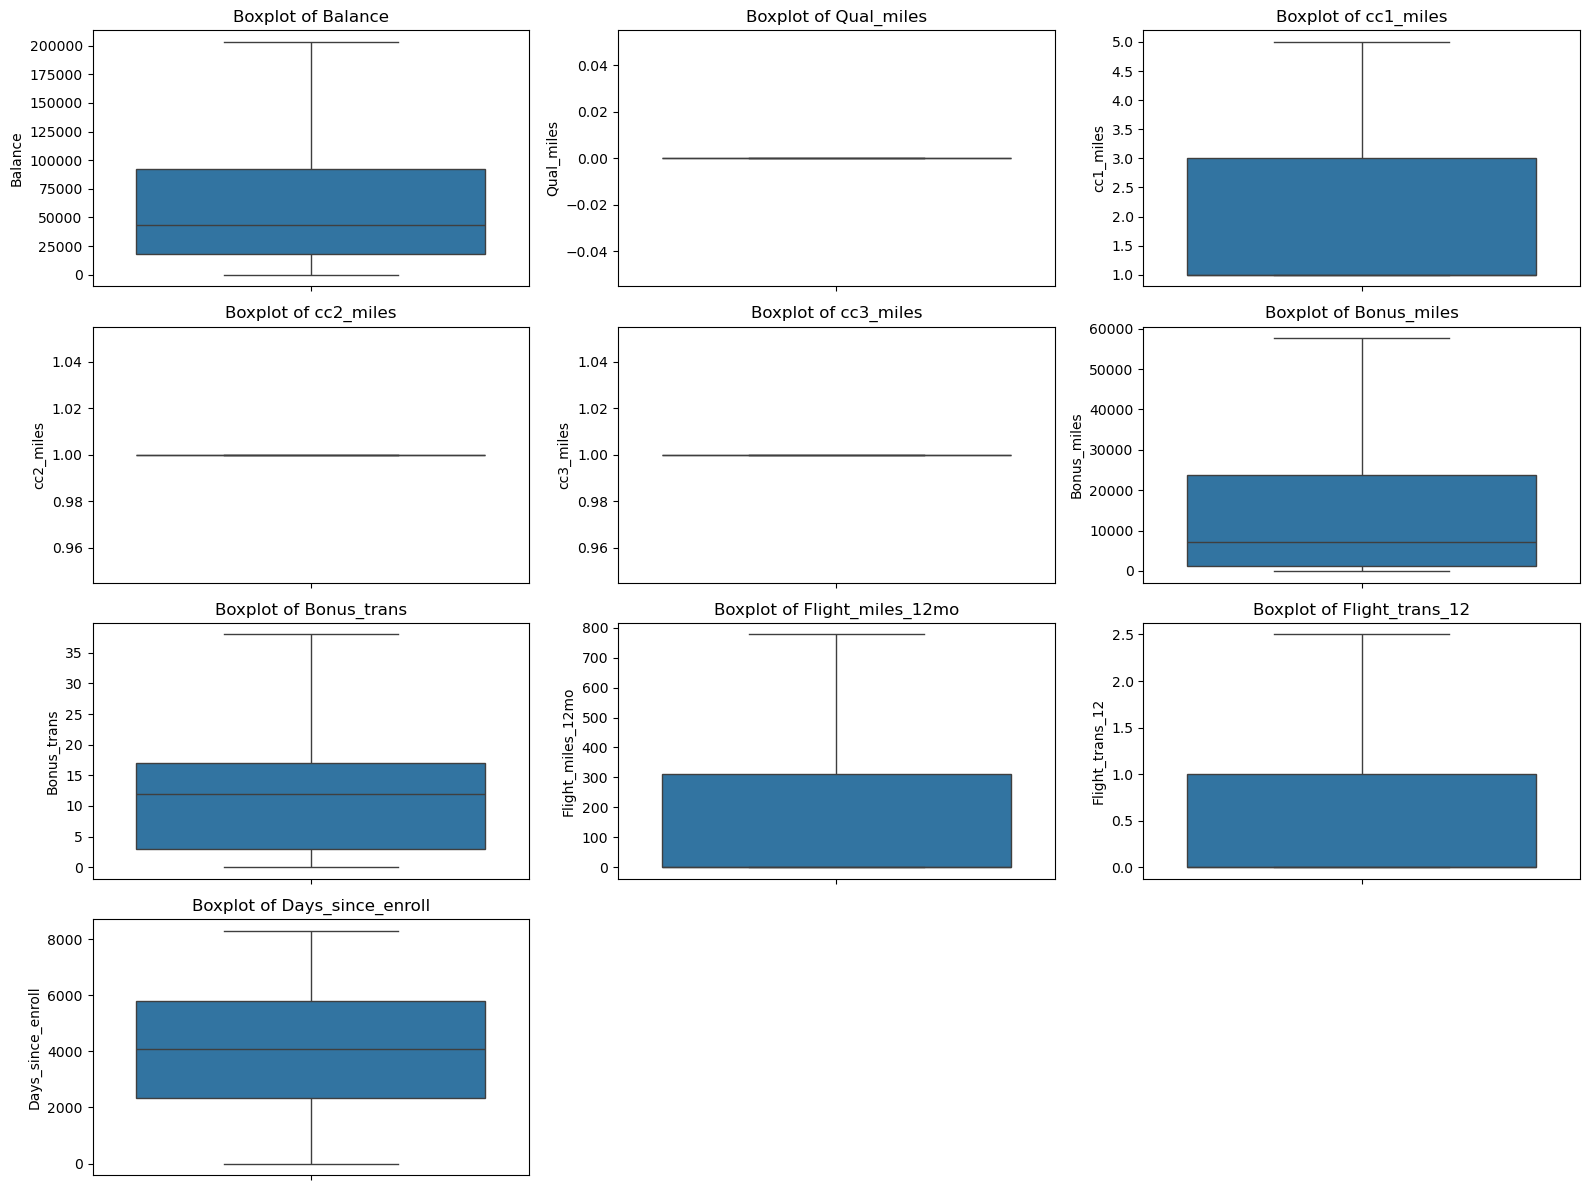

In [20]:
# 2. Boxplots
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

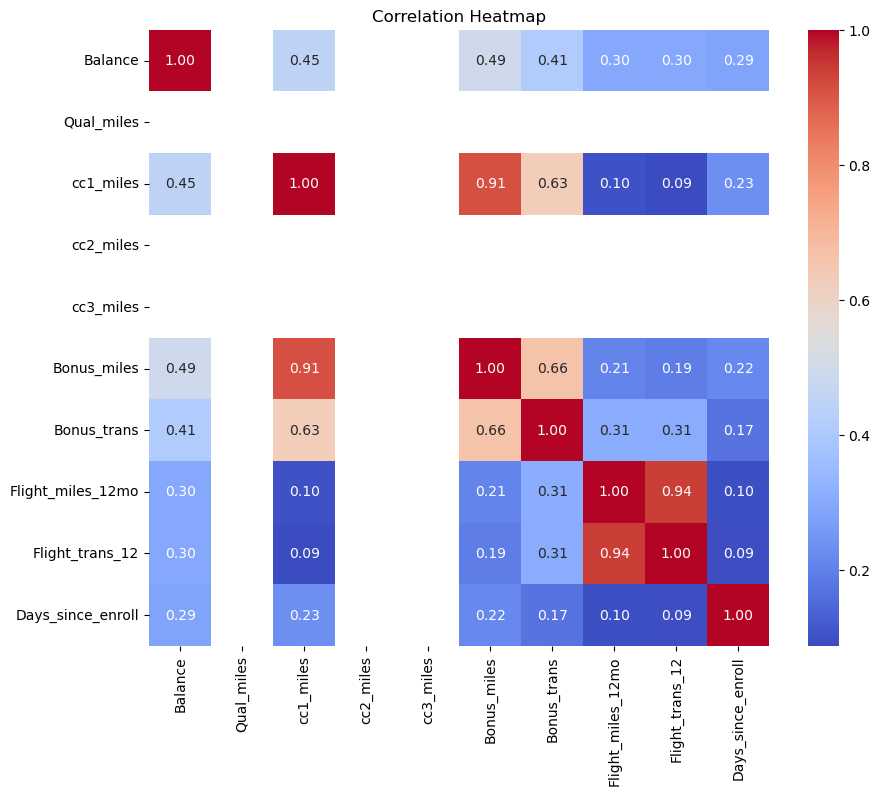

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [22]:
# Elbow Method to find optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 11)

In [23]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

Text(0, 0.5, 'Inertia')

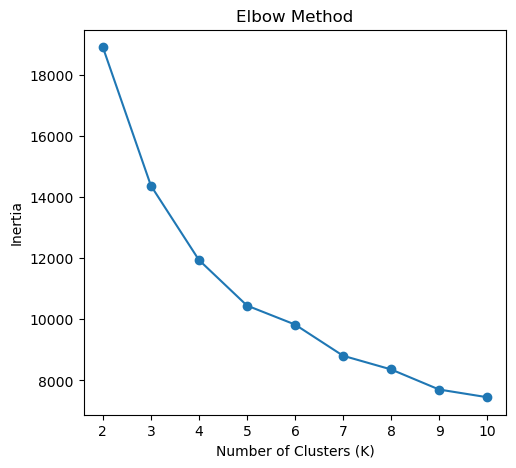

In [24]:
# Plot Elbow Curve and Silhouette Scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')


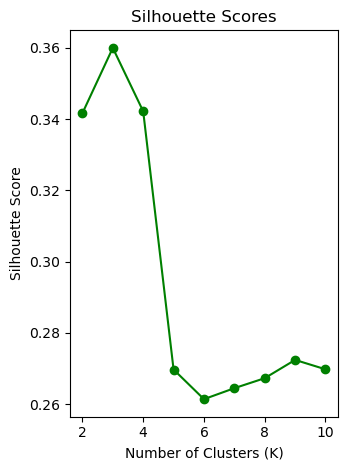

In [25]:
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

In [27]:

# Add cluster labels to original df
df['KMeans_Cluster'] = kmeans_labels

In [28]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)                                                                                                

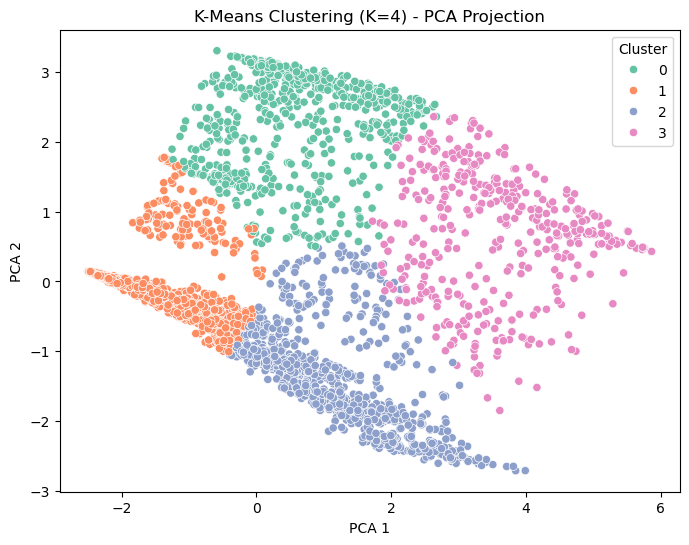

In [29]:

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set2')
plt.title('K-Means Clustering (K=4) - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [30]:
# Basic cluster characteristics
df.groupby('KMeans_Cluster')[numerical_cols].mean()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
KMeans_Cluster,,,,,,,,,,
0,75890.129310,0.0,1.221003,1.0,1.0,7668.947100,10.526646,637.977273,2.070533,4093.648903
1,32086.797005,0.0,1.142708,1.0,1.0,3549.883854,6.060937,12.071875,0.063542,3590.909896
2,90551.551954,0.0,3.502383,1.0,1.0,30873.252145,16.934223,26.764538,0.122974,4727.039085
3,127545.009566,0.0,4.053571,1.0,1.0,44726.799107,24.882653,647.349490,2.024235,5115.204082


In [31]:
linked = linkage(X_scaled, method='ward')


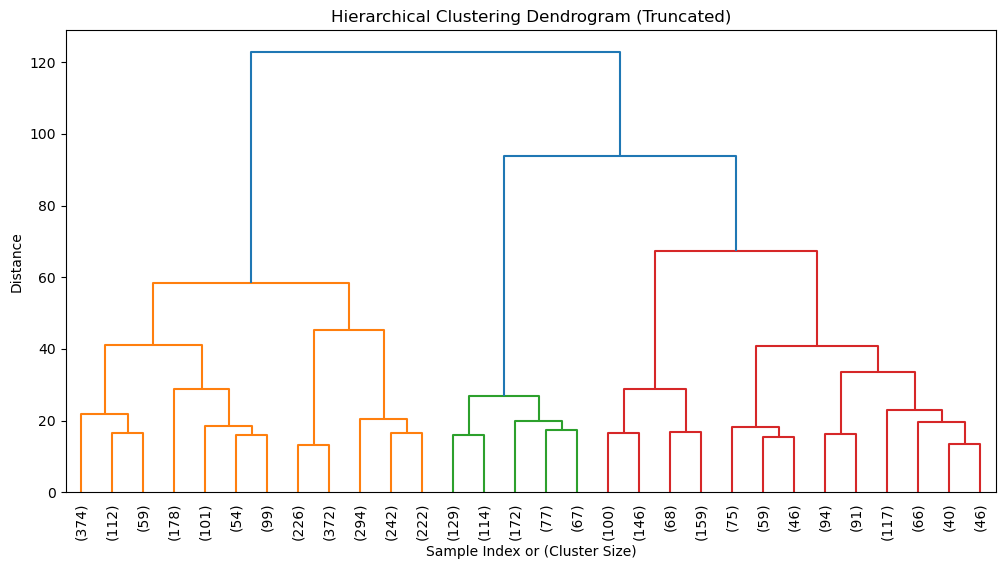

In [32]:
# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

In [33]:
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

In [34]:
df['Hierarchical_Cluster'] = hc_labels


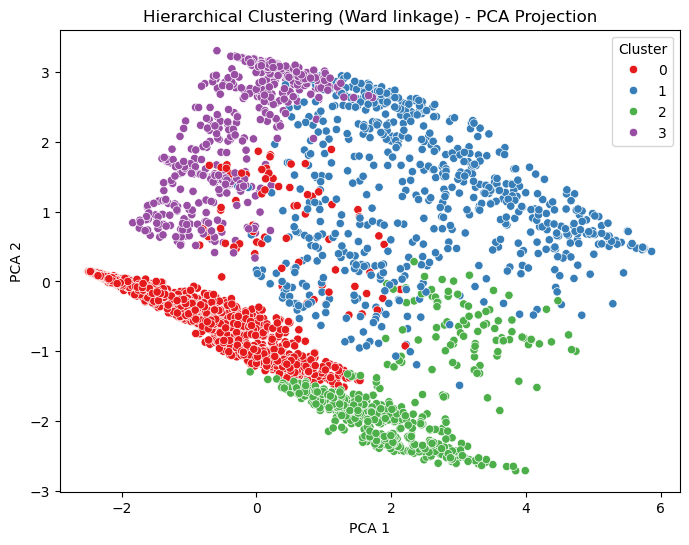

In [35]:
# Visualize with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hc_labels, palette='Set1')
plt.title('Hierarchical Clustering (Ward linkage) - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [120]:
# Initial parameters (you can tune later)
dbscan = DBSCAN(eps=1, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

In [121]:
df['DBSCAN_Cluster'] = db_labels
df.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster
0,28143.0,0.0,1.0,1.0,1.0,174.0,1.0,0.0,0.0,7000.0,0,1,0,0
1,19244.0,0.0,1.0,1.0,1.0,215.0,2.0,0.0,0.0,6968.0,0,1,0,0
2,41354.0,0.0,1.0,1.0,1.0,4123.0,4.0,0.0,0.0,7034.0,0,1,0,0
3,14776.0,0.0,1.0,1.0,1.0,500.0,1.0,0.0,0.0,6952.0,0,1,0,0
4,97752.0,0.0,4.0,1.0,1.0,43300.0,26.0,777.5,2.5,6935.0,1,3,1,1


In [124]:
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
n_noise,n_clusters

(225, 6)

In [126]:
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 6
Estimated number of noise points: 225


In [128]:
# Silhouette Score (only if >1 clusters exist)
if n_clusters > 1:
    score = silhouette_score(X_scaled, db_labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette score not available with <2 clusters.")

Silhouette Score: 0.093


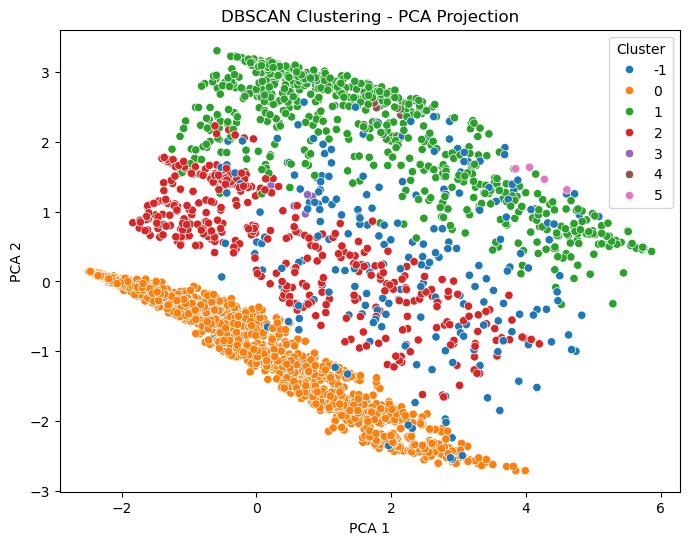

In [129]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=db_labels, palette='tab10')
plt.title('DBSCAN Clustering - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [133]:
# View average values for each feature by cluster (KMeans example)
print("K-Means Cluster Summary:")
print(df.groupby('KMeans_Cluster')[numerical_cols].mean())

print("\nHierarchical Cluster Summary:")
print(df.groupby('Hierarchical_Cluster')[numerical_cols].mean())

# DBSCAN: exclude noise (-1) from summary
print("\nDBSCAN Cluster Summary (excluding noise):")
print(df[df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')[numerical_cols].mean())

K-Means Cluster Summary:
                      Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                               
0                75890.129310         0.0   1.221003        1.0        1.0   
1                32086.797005         0.0   1.142708        1.0        1.0   
2                90551.551954         0.0   3.502383        1.0        1.0   
3               127545.009566         0.0   4.053571        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                  
0                7668.947100    10.526646         637.977273         2.070533   
1                3549.883854     6.060937          12.071875         0.063542   
2               30873.252145    16.934223          26.764538         0.122974   
3               44726.799107    24.882653         647.349490         2.024235   

                Day